<a href="https://colab.research.google.com/github/olgasherbiena/KPI/blob/IDA/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

## Generate Data

In [2]:
dataset_path = kagglehub.dataset_download("albertobircoci/support-ticket-priority-dataset-50k")
#print("Path to dataset files:", dataset_path)

support_ticket_data = pd.read_csv(os.path.join(dataset_path, "Support_tickets.csv"))

100%|██████████| 1.17M/1.17M [00:00<00:00, 37.3MB/s]

Extracting files...


In [4]:
print(support_ticket_data.head())

    ticket_id day_of_week  day_of_week_num  company_id company_size  \
0  1000000000         Wed                3      100015        Small   
1  1000000001         Sat                6      100023        Small   
2  1000000002         Mon                1      100012        Small   
3  1000000003         Wed                3      100003        Small   
4  1000000004         Mon                1      100019        Small   

   company_size_cat    industry  industry_cat customer_tier  \
0                 1       media             7         Basic   
1                 1  healthcare             5         Basic   
2                 1      gaming             4         Basic   
3                 1       media             7          Plus   
4                 1   ecommerce             2          Plus   

   customer_tier_cat  ...  downtime_min payment_impact_flag  \
0                  1  ...             6                   0   
1                  1  ...             2                   0   
2    

In [ ]:
# --- 1. ВИЗНАЧЕННЯ ОЗНАК (КОРЕКТНИЙ НАБІР) ---
# ЧИСЛОВІ ОЗНАКИ (для масштабування)
numerical_features = [
    #'day_of_week_num',
    'customers_affected'
]
# КАТЕГОРІАЛЬНІ ОЗНАКИ (для One-Hot Encoding)
categorical_features = [
    'company_size_cat',  'region_cat',
    'customer_tier_cat'
]
# ЦІЛЬОВА ЗМІННА
y_text = support_ticket_data['priority_cat']

# --- 2. СТВОРЕННЯ ЦІЛЬОВОЇ ЗМІННОЇ (y) ---
le = LabelEncoder()
y_encoded = le.fit_transform(support_ticket_data['priority_cat'])
priorities = le.classes_ # ['High', 'Low', 'Medium']
colors = ['tab:red', 'tab:green', 'tab:blue'] # Кольори для 3 класів


# --- 3. КОНВЕЄР ДЛЯ ОБРОБКИ ОЗНАК ---
preprocessor = ColumnTransformer(
    transformers=[
        # A. Обробка ЧИСЛОВИХ: Заповнення NaN (середнім) + Масштабування
        ('num',
         Pipeline([('imputer', SimpleImputer(strategy='mean')),
                   ('scaler', StandardScaler())]),
         numerical_features),

        # B. Обробка КАТЕГОРІАЛЬНИХ: One-Hot Encoding
        ('cat',
         Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))]),
         categorical_features)
    ],
    remainder='drop'
)

# Створення вихідної матриці X та її обробка
X = support_ticket_data[numerical_features + categorical_features].copy()
X_scaled = preprocessor.fit_transform(X)

print(f"Матриця X_scaled успішно створена. Розмірність: {X_scaled.shape}")

Матриця X_scaled успішно створена. Розмірність: (50000, 10)


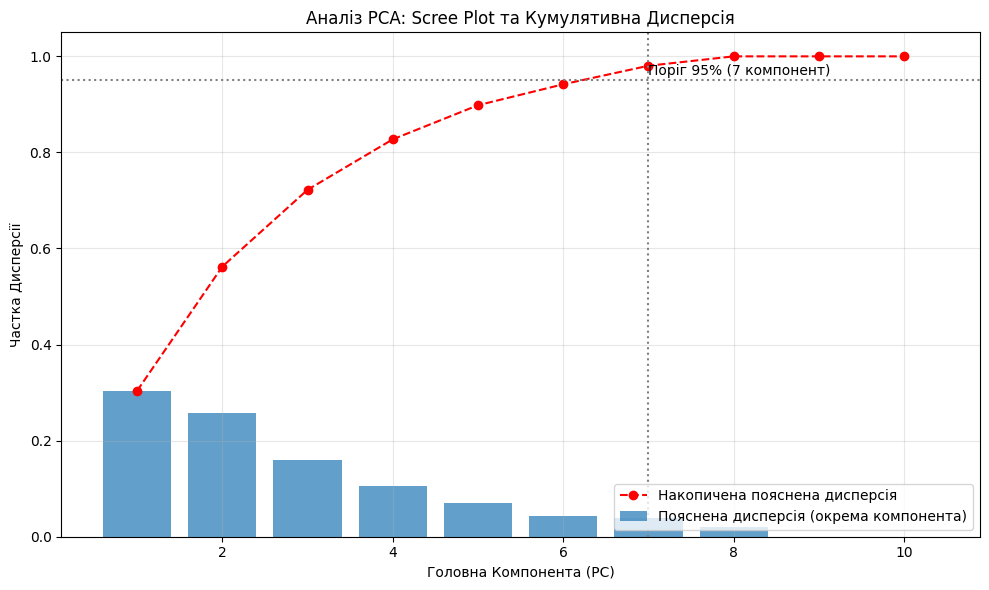


Оптимальна k для 95% дисперсії: 7


In [ ]:
# --- 1. РОЗРАХУНОК PCA З НУЛЯ (FROM SCRATCH) ---
n = X_scaled.shape[0]

# 1. Обчислення коваріаційної матриці
cov_mat = (X_scaled.T @ X_scaled) / (n - 1)

# 2. Ейгенрозклад
eigvals, eigvecs = np.linalg.eigh(cov_mat)

# 3. Сортування результатів у ЗСПАДАЮЧОМУ порядку
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
# eigvecs = eigvecs[:, order] # Не потрібні для Scree Plot

# --- 2. АНАЛІЗ ДИСПЕРСІЇ ---
explained_variance_ratio = eigvals / eigvals.sum()
evr = explained_variance_ratio
cum_evr = np.cumsum(evr)
n_components = len(evr)

# Визначаємо кількість компонент для 95% дисперсії
n_components_95 = np.argmax(cum_evr >= 0.95) + 1

# --- 3. Scree Plot ---
plt.figure(figsize=(10, 6))

plt.bar(range(1, n_components + 1), evr, alpha=0.7, label='Пояснена дисперсія (окрема компонента)')
plt.plot(range(1, n_components + 1), cum_evr, marker='o', color='red',
         linestyle='--', label='Накопичена пояснена дисперсія')

plt.axhline(0.95, linestyle=':', linewidth=1.5, color='gray')
plt.text(n_components * 0.7, 0.955, f'Поріг 95% ({n_components_95} компонент)',
         va='bottom', color='black', fontsize=10)
plt.axvline(n_components_95, color='gray', linestyle=':', linewidth=1.5)

plt.xlabel('Головна Компонента (PC)')
plt.ylabel('Частка Дисперсії')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.title('Аналіз PCA: Scree Plot та Кумулятивна Дисперсія')
plt.tight_layout()
plt.show()

print(f"\nОптимальна k для 95% дисперсії: {n_components_95}")

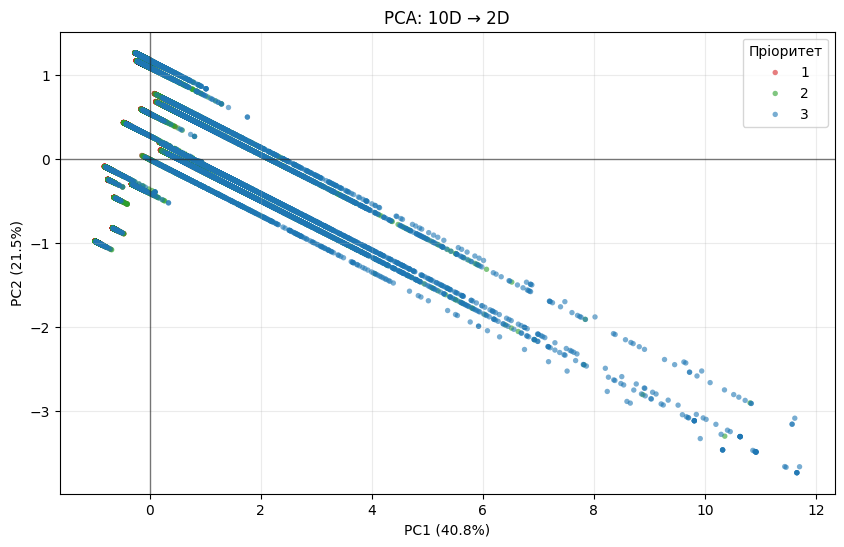

In [ ]:
from sklearn.manifold import TSNE

# --- 1. PCA 14D → 2D для Візуалізації ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pc1, pc2 = X_pca[:, 0], X_pca[:, 1]
explained_variance_pc1 = pca.explained_variance_ratio_[0]
explained_variance_pc2 = pca.explained_variance_ratio_[1]

# --- 2. t-SNE 14D → 2D для Візуалізації ---
# Створюємо невелику вибірку, оскільки t-SNE повільний
sample_size = 5000
np.random.seed(42)
total_samples = X_scaled.shape[0]
sample_indices = np.random.choice(total_samples, size=sample_size, replace=False)

X_sample = X_scaled[sample_indices]
y_sample_encoded = y_encoded[sample_indices]

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_sample)
tsne1, tsne2 = X_tsne[:, 0], X_tsne[:, 1]

# --- 3. ВІЗУАЛІЗАЦІЯ ---
n_classes = len(priorities)
y = y_encoded

# Створюємо одну фігуру для одного графіка (замість subplots)
plt.figure(figsize=(10, 6))
ax = plt.gca() # Отримуємо поточну вісь

# Графік PCA
for cls, name, c in zip(range(n_classes), priorities, colors):
    idx = (y == cls)
    ax.scatter(pc1[idx], pc2[idx], label=name, c=c, s=15, edgecolor='none', alpha=0.6)
ax.axhline(0, linewidth=1, color='black', alpha=0.5)
ax.axvline(0, linewidth=1, color='black', alpha=0.5)
ax.set_xlabel(f'PC1 ({explained_variance_pc1*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_variance_pc2*100:.1f}%)')
ax.set_title(f'PCA: {X_scaled.shape[1]}D → 2D')
ax.legend(title="Пріоритет")
ax.grid(True, alpha=0.25)


In [ ]:
# Використовуємо оптимальну k, знайдену на Scree Plot (наприклад, 95% -> 9 компонент)
# Замініть 9 на значення, яке ви отримали на своєму графіку Scree Plot!
optimal_k = 8

# 1. Розбиття на вибірки
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)

# --- A. Система 1: Навчання на повних даних (14D) ---
model_full = LogisticRegression(max_iter=1000, random_state=42)
start_time_full = time.time()
model_full.fit(X_train_full, y_train)
time_full = time.time() - start_time_full
accuracy_full = model_full.score(X_test_full, y_test)

# --- B. Система 2: Навчання на зменшених даних (k=9D) ---
pca_optimized = PCA(n_components=optimal_k, random_state=42)
X_train_pca = pca_optimized.fit_transform(X_train_full)
X_test_pca = pca_optimized.transform(X_test_full)

model_pca = LogisticRegression(max_iter=1000, random_state=42)
start_time_pca = time.time()
model_pca.fit(X_train_pca, y_train)
time_pca = time.time() - start_time_pca
accuracy_pca = model_pca.score(X_test_pca, y_test)

# --- 3. ВИСНОВКИ ---
print("\n--- ПОРІВНЯННЯ РЕЗУЛЬТАТІВ КЛАСИФІКАЦІЇ (Logistic Regression) ---")
print(f"Початкова розмірність: {X_scaled.shape[1]}D")
print(f"PCA розмірність: {optimal_k}D (Збережено 95% дисперсії)")
print("----------------------------------------------------------------------")
print(f"1. Повні дані (14D): Точність={accuracy_full:.4f}, Час={time_full:.4f} сек")
print(f"2. Зменшені дані (9D): Точність={accuracy_pca:.4f}, Час={time_pca:.4f} сек")
print("----------------------------------------------------------------------")
print(f"Зміна точності: {accuracy_pca - accuracy_full:.4f}")
print(f"Прискорення навчання: {time_full / time_pca:.1f} разів")


--- ПОРІВНЯННЯ РЕЗУЛЬТАТІВ КЛАСИФІКАЦІЇ (Logistic Regression) ---
Початкова розмірність: 10D
PCA розмірність: 8D (Збережено 95% дисперсії)
----------------------------------------------------------------------
1. Повні дані (14D): Точність=0.6808, Час=0.3937 сек
2. Зменшені дані (9D): Точність=0.6812, Час=0.5500 сек
----------------------------------------------------------------------
Зміна точності: 0.0004
Прискорення навчання: 0.7 разів


# K-means Clustering

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans

from sklearn import set_config
set_config(display='text')

Image shape: (1080, 1080, 3)
dtype: float32


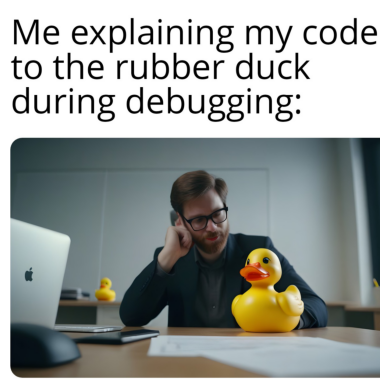

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

file_name = "duck2.png"
img = mpimg.imread(file_name)
H, W, C = img.shape
print("Image shape:", img.shape)
print("dtype:", img.dtype)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
pixels = img.reshape(-1, 3)

#K-means працює у цьому 3-вимірному просторі: шукає «близькі» вектори і об’єднує їх у кластери
k = 64  # кількість кольорів
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(pixels)

KMeans(n_clusters=64, n_init=10, random_state=0)

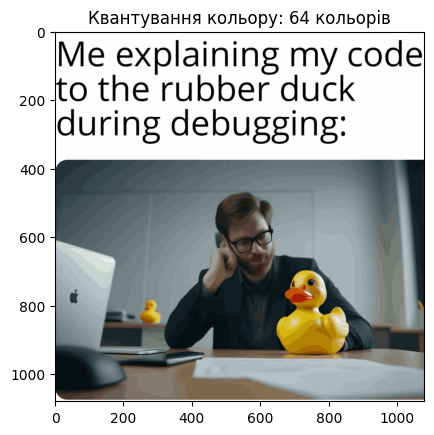

In [ ]:
new_colors = kmeans.cluster_centers_[kmeans.labels_]
quantized_img = new_colors.reshape(img.shape)

plt.imshow(quantized_img)
plt.title(f'Квантування кольору: {k} кольорів')
plt.show()

In [ ]:
#Формат uint8 дозволяє закодувати 16,7 мільйона кольорів (кількість можливих комбінацій у зображені з трьома каналами)
#256×256×256 (але кожне конкретне зображення зазвичай містить значно менше унікальних кольорів)
unique_colors = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])

Унікальних кольорів у вихідному зображені: 89317
Унікальних кольорів в перетвореному зображені: 64


In [ ]:
pixels = img.reshape(-1, 3)

#K-means працює у цьому 3-вимірному просторі: шукає «близькі» вектори і об’єднує їх у кластери
k = 32  # кількість кольорів
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(pixels)

KMeans(n_clusters=32, n_init=10, random_state=0)

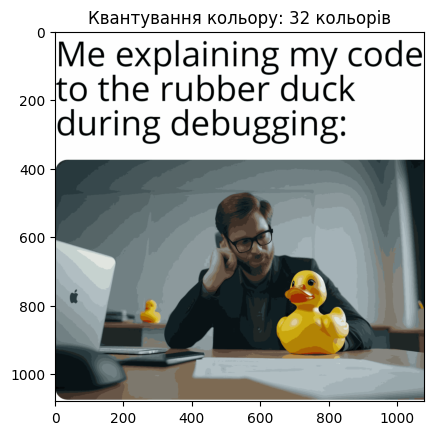

In [ ]:
new_colors = kmeans.cluster_centers_[kmeans.labels_]
quantized_img = new_colors.reshape(img.shape)

plt.imshow(quantized_img)
plt.title(f'Квантування кольору: {k} кольорів')
plt.show()

In [ ]:
#Формат uint8 дозволяє закодувати 16,7 мільйона кольорів (кількість можливих комбінацій у зображені з трьома каналами)
#256×256×256 (але кожне конкретне зображення зазвичай містить значно менше унікальних кольорів)
unique_colors = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])

Унікальних кольорів у вихідному зображені: 89317
Унікальних кольорів в перетвореному зображені: 32


In [ ]:

pixels = img.reshape(-1, 3)

#K-means працює у цьому 3-вимірному просторі: шукає «близькі» вектори і об’єднує їх у кластери
k = 16  # кількість кольорів
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(pixels)

KMeans(n_clusters=16, n_init=10, random_state=0)

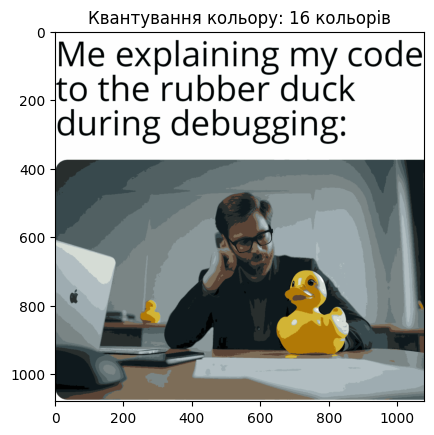

In [ ]:
new_colors = kmeans.cluster_centers_[kmeans.labels_]
quantized_img = new_colors.reshape(img.shape)

plt.imshow(quantized_img)
plt.title(f'Квантування кольору: {k} кольорів')
plt.show()

In [ ]:
#Формат uint8 дозволяє закодувати 16,7 мільйона кольорів (кількість можливих комбінацій у зображені з трьома каналами)
#256×256×256 (але кожне конкретне зображення зазвичай містить значно менше унікальних кольорів)
unique_colors = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])

Унікальних кольорів у вихідному зображені: 89317
Унікальних кольорів в перетвореному зображені: 16


In [ ]:

pixels = img.reshape(-1, 3)

#K-means працює у цьому 3-вимірному просторі: шукає «близькі» вектори і об’єднує їх у кластери
k = 8  # кількість кольорів
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(pixels)

KMeans(n_init=10, random_state=0)

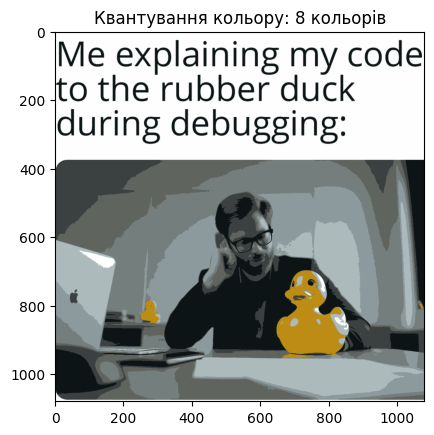

In [ ]:
new_colors = kmeans.cluster_centers_[kmeans.labels_]
quantized_img = new_colors.reshape(img.shape)

plt.imshow(quantized_img)
plt.title(f'Квантування кольору: {k} кольорів')
plt.show()

In [ ]:
#Формат uint8 дозволяє закодувати 16,7 мільйона кольорів (кількість можливих комбінацій у зображені з трьома каналами)
#256×256×256 (але кожне конкретне зображення зазвичай містить значно менше унікальних кольорів)
unique_colors = np.unique(img.reshape(-1, 3), axis=0)
print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])

Унікальних кольорів у вихідному зображені: 89317
Унікальних кольорів в перетвореному зображені: 8


# Обробка та класифікація текстових даних

In [13]:
import pandas as pd
import gzip
import simplejson
import os

def parse(filename):
  f = open(filename, 'r', encoding='latin-1')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry


In [22]:
all_entries = []
for e in parse("first_3000.txt"):
  all_entries.append(e)
  #print(simplejson.dumps(e))
df = pd.DataFrame(all_entries)
product_titles_series = df['review/score'].unique().tolist()
print(f"✅ DataFrame 'df' створено з {len(df)} записів.")
print(f"Перші 5 назв продуктів: {product_titles_series}")

✅ DataFrame 'df' створено з 272 записів.
Перші 5 назв продуктів: ['4.0', '5.0', '1.0', '3.0', '2.0']
